# Libraries and Data Load

## Load Libraries

In [1]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os
import gc #garbage collector
import random #random seed generator
import pandas_profiling # requires import and prior install 

#Timer
from timeit import default_timer as timer #import a timer

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
from pandas_profiling import ProfileReport
import math #math functions
import numpy as np    #numerical package
from patsy import dmatrix, demo_data, ContrastMatrix, Poly

#Scikit learn
from math import sqrt
import sklearn as sk  #scikit learn
import sklearn.linear_model 
from sklearn.linear_model import LogisticRegression as LR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample #sampling
from sklearn.model_selection import train_test_split as tts, KFold #train test split
from sklearn.decomposition import PCA #principal components
from imblearn.over_sampling import SMOTE #synthetic minority oversampling technique
from sklearn.metrics import classification_report as CR,confusion_matrix, roc_curve, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, average_precision_score #for 2-class model
from sklearn.preprocessing import MinMaxScaler as Scaler, PolynomialFeatures as poly # used for variable scaling data
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.ensemble import RandomForestClassifier as RFC, ExtraTreesClassifier as ETC, GradientBoostingClassifier as GBC,AdaBoostClassifier as ABC  # Random Forest package
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import make_pipeline


from scipy import misc, stats as st #Lots of stuff here
import itertools

import statsmodels.api as sm
import pyreadstat

#Graphing
import seaborn as sns
import pydot  #For model plotting
import graphviz #python-graphviz package
from IPython.display import SVG #Same here
import matplotlib.pyplot as plt #plotting
import matplotlib #image save
from matplotlib.pyplot import imshow #Show images
from PIL import Image #Another image utility
import cv2 #more image utilities

%matplotlib inline

os.chdir('D:\MI')
##############################################################################################################################

## Load Data

In [2]:
##############################################################################################################################
mydata=pd.read_sas('D:/MI/Y2019.XPT')
##############################################################################################################################

# Data Preparation

## Determine Shape

In [3]:
mydata.shape

(418268, 342)

## Determine which Age Groups to Use

In [4]:
pd.crosstab(mydata._AGE_G,mydata.CVDINFR4[mydata.CVDINFR4==1],normalize = 'columns', margins=True)
#18 to 24 almost 0% MI
#25 to 34 1.1% MI
#35 to 44 2.8% MI
#45 to 54 8.4% MI
#55 to 64 21% MI
#65 + 66% MI

CVDINFR4,1.0,All
_AGE_G,,
1.0,0.004432,0.004432
2.0,0.011120,0.011120
3.0,0.027739,0.027739
4.0,0.083792,0.083792
5.0,0.208371,0.208371
6.0,0.664547,0.664547


## Reduce Variable Set and Scope

We select variables from previous research and those of interest for investigation.

In [5]:
temp1=mydata
temp1=temp1[['CVDINFR4',
             '_AGE_G', '_IMPRACE', 'SEXVAR', 'MARITAL', 'VETERAN3', 
             'INCOME2','EDUCA', 'EMPLOY1','RENTHOM1',
             'GENHLTH', 'SMOKE100', 'USENOW3','_PA300R3', 'ALCDAY5',
             'TOLDHI2', '_RFHYPE5', '_RFBMI5', 
             'DIABETE4', 'PHYSHLTH', 'MENTHLTH',  'ADDEPEV3','CVDSTRK3', 'ASTHMA3', 
             'CHCSCNCR','CHCOCNCR', 'CHCCOPD2','CHCKDNY2','HAVARTH4',
             'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1',
             '_STATE', '_LLCPWT', '_STSTR', '_PSU']]

pd.crosstab(temp1._AGE_G, temp1.CVDINFR4, normalize='columns')


CVDINFR4,1.0,2.0,7.0,9.0
_AGE_G,,,,
1.0,0.004432,0.063629,0.038933,0.010256
2.0,0.011120,0.111076,0.065617,0.030769
3.0,0.027739,0.124147,0.086177,0.025641
4.0,0.083792,0.150002,0.110674,0.307692
5.0,0.208371,0.200408,0.202975,0.179487
6.0,0.664547,0.350737,0.495626,0.446154


##  We Restrict Analyses to Age Cat 3 through 6

These groups account for 98%+ of the observations of MI.

In [6]:
temp1=temp1.loc[temp1['_AGE_G']>=3] #filter excludes 18 to 34 year olds, less than 1.2% of MI in dataset

## Handle Missing

Rows missing 20% or more are eliminated (8 or more variables, 18 observations eliminated).  
Columns missing 20% or more observations are eliminated (69853 or more observations, 0 eliminated).

### Columns

We verify that all selected columns have LT 20% missing.

In [7]:
a=temp1.isnull().sum() #count the nulls by column
print(a.sort_values(ascending=False).head(10))

ALCDAY5     14702
USENOW3     13500
SMOKE100    12907
TOLDHI2     11857
INCOME2      5431
EMPLOY1      2233
VETERAN3     1126
MARITAL        45
PHYSHLTH       28
EDUCA          25
dtype: int64


### Rows

We investigate the same by row

In [8]:
b=temp1.isnull().sum(axis=1) #count the nulls by column
b=b.sort_values(ascending=False)
print(b.head(20))

58979     26
59974     26
60190     26
60298     26
339417    19
58498     19
58968     19
633       18
42        12
85152     10
60400      9
404345     9
326094     8
335930     8
3175       8
219506     8
342909     8
2250       8
326736     7
34187      7
dtype: int64


In [9]:
todrop=b.head(18).index
todrop

Int64Index([ 58979,  59974,  60190,  60298, 339417,  58498,  58968,    633,
                42,  85152,  60400, 404345, 326094, 335930,   3175, 219506,
            342909,   2250],
           dtype='int64')

## Drop the Rows and Plot Missing

<AxesSubplot:>

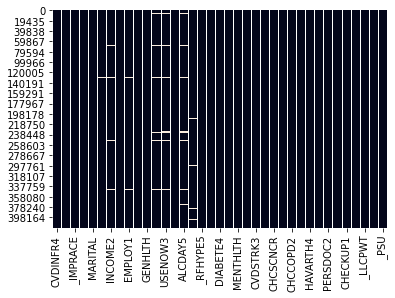

In [10]:
temp1 = temp1.drop(todrop)                    
sns.heatmap(temp1.isnull(), cbar=False)

## Impute Median
Given the small number of missing values remaining, impute median.

In [11]:
num=temp1.isna().sum().sum()
den=temp1.shape[0]*temp1.shape[1]
print('missing:', num/den)
temp1=temp1.fillna(temp1.median())
print(temp1.shape)

missing: 0.00478068743431256
(349243, 37)


## Rename Columns

In [12]:
mydict={'CVDINFR4':'MI','_AGE_G':'Age', '_IMPRACE':'Race', 'SEXVAR':'Male', 'MARITAL':'Unmarried', 'VETERAN3':'Veteran', 
             'INCOME2':'LowIncome','EDUCA':'LowEducation', 'EMPLOY1':'Unemployed', 'RENTHOM1':'RentHome',
             'GENHLTH':'PoorHealth', 'SMOKE100':'Smoker','USENOW3':'ChewSnuff',
             '_PA300R3':'NoExercise', 'ALCDAY5':'DrinksDaily',
            'TOLDHI2':'HighCholesterol', '_RFHYPE5':'HighBP', '_RFBMI5':'HighBMI', 
             'DIABETE4':'Diabetes', 'PHYSHLTH':'PhysicalHealth','MENTHLTH':'MentalHealth',
             'ADDEPEV3':'Depression','CVDSTRK3':'Stroke', 
            'ASTHMA3':'Asthma','CHCSCNCR':'SkinCancer', 'CHCOCNCR':'Cancer', 
            'CHCCOPD2':'COPD','CHCKDNY2':'Kidney','HAVARTH4':'Arthritis', 
             'HLTHPLN1':'NoHealthPlan', 'PERSDOC2':'NoDoctor', 'MEDCOST':'Cost', 'CHECKUP1':'NoCheckup',
             '_STATE':'State', '_LLCPWT':'Weights', '_STSTR':'Stratum', '_PSU':'PSU'}
temp1=temp1.rename(columns=dict(mydict))

# Recodes

## MI, 1=YES

Has a doctor, nurse, or other health professional ever told you that you had any of the following? Heart Attack
1=Yes, 2=No, 7=Don't Know, 9=Refused

In [13]:
print(pd.value_counts(temp1.MI, normalize='columns'))
a_dict = {2:0, 7:0, 9:0}  #Modal response impute
temp1['MI']=temp1['MI'].replace(dict(a_dict))
print(pd.value_counts(temp1.MI, normalize='columns'))

2.0    0.924918
1.0    0.068689
7.0    0.005861
9.0    0.000533
Name: MI, dtype: float64
0.0    0.931311
1.0    0.068689
Name: MI, dtype: float64


## Age Group 35-44, 45-54, 55-64, and 65+

Age Group 35-44 is the referent group.

In [14]:
print(pd.value_counts(temp1.Age, normalize='columns'))
b0_dict={3:0, 4:0, 5:0, 6:1} #Age 65+
b1_dict={3:0,4:0, 5:1, 6:0} #Age 55-64
b2_dict={3:0,4:1, 5:0, 6:0} #Age 45-54

temp1['Age65']=temp1['Age'].replace(dict(b0_dict))
temp1['Age55_64']=temp1['Age'].replace(dict(b1_dict))
temp1['Age45_54']=temp1['Age'].replace(dict(b2_dict))
print(pd.value_counts(temp1.Age65, normalize='columns'))
print(pd.value_counts(temp1.Age55_64, normalize='columns'))
print(pd.value_counts(temp1.Age45_54, normalize='columns'))
temp1=temp1.drop(columns=['Age'])

6.0    0.442941
5.0    0.240566
4.0    0.174847
3.0    0.141646
Name: Age, dtype: float64
0.0    0.557059
1.0    0.442941
Name: Age65, dtype: float64
0.0    0.759434
1.0    0.240566
Name: Age55_64, dtype: float64
0.0    0.825153
1.0    0.174847
Name: Age45_54, dtype: float64


## Race Recode:  Black, Hispanic, Other with 1=Minority
Imputed race/ethnicity value
1=White NH, 2=Black NH, 3=Asian NH, 4=AI/NA NH, 5=Hispanic, 6=Other NH
White NH is the referent group.

In [15]:
pd.crosstab(temp1.Race, temp1.MI, normalize='index') 

MI,0.0,1.0
Race,,
1.0,0.929954,0.070046
2.0,0.935730,0.064270
3.0,0.966590,0.033410
4.0,0.889398,0.110602
5.0,0.949986,0.050014
6.0,0.912449,0.087551


In [16]:
print(pd.value_counts(temp1.Race, normalize='columns'))
c_dict={2:1, 1:0, 3:0, 4:0, 5:0, 6:0}
d_dict={5:1, 1:0, 2:0, 3:0, 4:0, 6:0}
e_dict={1:0, 2:0, 3:1, 4:1, 5:0, 6:1}
temp1['Black']=temp1['Race'].replace(dict(c_dict))
temp1['Hispanic']=temp1['Race'].replace(dict(d_dict))
temp1['Other']=temp1['Race'].replace(dict(e_dict))
print(pd.value_counts(temp1.Black, normalize='columns'))
print(pd.value_counts(temp1.Hispanic, normalize='columns'))
print(pd.value_counts(temp1.Other, normalize='columns'))
temp1=temp1.drop(columns=['Race'])

1.0    0.789144
2.0    0.073823
5.0    0.073224
6.0    0.030775
3.0    0.017398
4.0    0.015637
Name: Race, dtype: float64
0.0    0.926177
1.0    0.073823
Name: Black, dtype: float64
0.0    0.926776
1.0    0.073224
Name: Hispanic, dtype: float64
0.0    0.936191
1.0    0.063809
Name: Other, dtype: float64


## Gender, 1=Male
Calculated sex variable

In [17]:
pd.crosstab(temp1.Male, temp1.MI, normalize='index')

MI,0.0,1.0
Male,,
1.0,0.907513,0.092487
2.0,0.950061,0.049939


In [18]:
print(pd.value_counts(temp1.Male, normalize='columns'))
f_dict={2:0, 1:1}
temp1['Male']=temp1['Male'].replace(dict(f_dict))
print(pd.value_counts(temp1.Male, normalize='columns'))

2.0    0.559324
1.0    0.440676
Name: Male, dtype: float64
0.0    0.559324
1.0    0.440676
Name: Male, dtype: float64


## Unmarried

1=Married, 2=Divorced, 3=Widowed, 4=Separated, 5=Never Married, 6=Member of Unmarried Couple, 9=Refused

We define PreviousMarriage as divorced, widowed, or separated.

We then defined NeverMarried.



In [19]:
pd.crosstab(temp1.Unmarried, temp1.MI, normalize='index')

MI,0.0,1.0
Unmarried,,
1.0,0.942809,0.057191
2.0,0.917610,0.082390
3.0,0.887851,0.112149
4.0,0.914216,0.085784
5.0,0.949610,0.050390
6.0,0.951989,0.048011
9.0,0.951552,0.048448


In [20]:
print(pd.value_counts(temp1.Unmarried, normalize='columns'))
g0_dict={1:0,2:1, 3:1, 4:1, 5:0, 6:0, 9:0} #divorced / widowed / separated
g1_dict={1:0,2:0, 3:0, 4:0, 5:1, 6:0, 9:0} #never married

temp1['PreviousMarriage']=temp1['Unmarried'].replace(dict(g0_dict))
temp1['NeverMarried']=temp1['Unmarried'].replace(dict(g1_dict))
temp1=temp1.drop(columns=['Unmarried'])

print(pd.value_counts(temp1.PreviousMarriage, normalize='columns'))
print(pd.value_counts(temp1.NeverMarried, normalize='columns'))

1.0    0.552730
2.0    0.154062
3.0    0.144661
5.0    0.095349
6.0    0.023677
4.0    0.021129
9.0    0.008392
Name: Unmarried, dtype: float64
0.0    0.680148
1.0    0.319852
Name: PreviousMarriage, dtype: float64
0.0    0.904651
1.0    0.095349
Name: NeverMarried, dtype: float64


## Veteran, 1=Veteran

Have you ever served on active duty in the United States Armed Forces, either in the regular military or the National Guard or military reserve unit?  

1=Yes, 2=No, 7/9=DK/Refused

In [21]:
pd.crosstab(temp1.Veteran, temp1.MI, normalize='index')

MI,0.0,1.0
Veteran,,
1.0,0.872503,0.127497
2.0,0.941021,0.058979
7.0,0.832061,0.167939
9.0,0.943005,0.056995


In [22]:
print(pd.value_counts(temp1.Veteran, normalize='columns'))
h0_dict={1:1, 2:0, 7:0, 9:0} #VetYes
temp1['Veteran']=temp1['Veteran'].replace(dict(h0_dict))
print(pd.value_counts(temp1.Veteran, normalize='columns'))

2.0    0.856243
1.0    0.141171
9.0    0.002210
7.0    0.000375
Name: Veteran, dtype: float64
0.0    0.858829
1.0    0.141171
Name: Veteran, dtype: float64


## Poor Income

1=<10K, 2=<15K, 3=<20K, 4=<25K, 5=<35K,6=<50K,7=<75K,8=>=75K, 77/99=DK, Refused

We use below 25K, below 75K, DK/Refused, with referent group of 75K+.

In [23]:
pd.crosstab(temp1.LowIncome,temp1.MI, normalize='index')

MI,0.0,1.0
LowIncome,,
1.0,0.888238,0.111762
2.0,0.866025,0.133975
3.0,0.886934,0.113066
4.0,0.899558,0.100442
5.0,0.913157,0.086843
6.0,0.927652,0.072348
7.0,0.944097,0.055903
8.0,0.965085,0.034915
77.0,0.907951,0.092049


In [24]:
print(pd.value_counts(temp1.LowIncome, normalize='columns'))
i0_dict={1:1, 2:1, 3:1, 4:1, 5:0, 6:0, 7:0, 8:0, 77:0,99:0}
i1_dict={1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:0, 77:0,99:0}
i2_dict={1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 77:1,99:1}
temp1['LT25K']=temp1['LowIncome'].replace(dict(i0_dict))
temp1['LT50K']=temp1['LowIncome'].replace(dict(i1_dict))
temp1['Income_DKR']=temp1['LowIncome'].replace(dict(i2_dict))
print(pd.value_counts(temp1.LT25K, normalize='columns'))
print(pd.value_counts(temp1.LT50K, normalize='columns'))
print(pd.value_counts(temp1.Income_DKR, normalize='columns'))
temp1=temp1.drop(columns=['LowIncome'])

8.0     0.289575
7.0     0.144338
6.0     0.109193
99.0    0.106800
5.0     0.081110
4.0     0.069928
77.0    0.067844
3.0     0.055182
2.0     0.039881
1.0     0.036150
Name: LowIncome, dtype: float64
0.0    0.798859
1.0    0.201141
Name: LT25K, dtype: float64
0.0    0.665359
1.0    0.334641
Name: LT50K, dtype: float64
0.0    0.825357
1.0    0.174643
Name: Income_DKR, dtype: float64


## Education Recode: Below HS, HS, Post-HS but Not College Grad

1=Never Attended, 2=Grades 1 through 8, 3=Grades 9-11, 4=Grade 12 / GED, 5=College 1 to 3 years, 6=College 4 or more years, 9=Refused

In [25]:
pd.crosstab(temp1.LowEducation,temp1.MI, normalize='index')

MI,0.0,1.0
LowEducation,,
1.0,0.906367,0.093633
2.0,0.883792,0.116208
3.0,0.877382,0.122618
4.0,0.915407,0.084593
5.0,0.927759,0.072241
6.0,0.953933,0.046067
9.0,0.938840,0.061160


In [26]:
print(pd.value_counts(temp1.LowEducation, normalize='columns'))
j_dict={1:1, 2:1, 3:1, 4:0, 5:0, 6:0, 9:0} #add 9 to referent group (very small)
k_dict={1:0, 2:0, 3:0, 4:1, 5:0, 6:0, 9:0}
l_dict={1:0, 2:0, 3:0, 4:0, 5:1, 6:0, 9:0} #not a college grad but post-HS
temp1['PreHS']=temp1['LowEducation'].replace(dict(j_dict))
temp1['HS']=temp1['LowEducation'].replace(dict(k_dict))
temp1['PostHS']=temp1['LowEducation'].replace(dict(l_dict))
print(pd.value_counts(temp1.PreHS, normalize='columns'))
print(pd.value_counts(temp1.HS, normalize='columns'))
print(pd.value_counts(temp1.PostHS, normalize='columns'))
temp1=temp1.drop(columns=['LowEducation'])

6.0    0.389030
5.0    0.272655
4.0    0.261108
3.0    0.045979
2.0    0.025157
9.0    0.004541
1.0    0.001529
Name: LowEducation, dtype: float64
0.0    0.927334
1.0    0.072666
Name: PreHS, dtype: float64
0.0    0.738892
1.0    0.261108
Name: HS, dtype: float64
0.0    0.727345
1.0    0.272655
Name: PostHS, dtype: float64


## Not Employed

1=Employed for Wages, 2=Self-Employed, 3=Out of work 1+, 4=Out of work <1, 5=Homemaker, 6=Student, 7=Retired, 8=Unable to Work, 9=Refused.

RetiredUnable=7, 8

OutofWork=3,4

OtherNotWorking=5,6,9

In [27]:
pd.crosstab(temp1.Unemployed,temp1.MI, normalize='index')

MI,0.0,1.0
Unemployed,,
1.0,0.973462,0.026538
2.0,0.957115,0.042885
3.0,0.924810,0.075190
4.0,0.953511,0.046489
5.0,0.955229,0.044771
6.0,0.977663,0.022337
7.0,0.897222,0.102778
8.0,0.847608,0.152392
9.0,0.948222,0.051778


In [28]:
print(pd.value_counts(temp1.Unemployed, normalize='columns'))
m0_dict={1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:0} # RetiredUnable...  refused added to referent group (very small)
m1_dict={1:0, 2:0, 3:1, 4:1, 5:0, 6:0, 7:0, 8:0, 9:0} # OutofWork
m2_dict={1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:0, 8:0, 9:0} # Other not Working
temp1['RetiredUnable']=temp1['Unemployed'].replace(dict(m0_dict))
temp1['OutofWork']=temp1['Unemployed'].replace(dict(m1_dict))
temp1['OtherNotWorking']=temp1['Unemployed'].replace(dict(m2_dict))
print(pd.value_counts(temp1.RetiredUnable, normalize='columns'))
print(pd.value_counts(temp1.OutofWork, normalize='columns'))
print(pd.value_counts(temp1.OtherNotWorking, normalize='columns'))
temp1=temp1.drop(columns=['Unemployed'])

7.0    0.368523
1.0    0.357456
2.0    0.094009
8.0    0.080737
5.0    0.055257
3.0    0.017670
4.0    0.014720
9.0    0.008295
6.0    0.003333
Name: Unemployed, dtype: float64
0.0    0.55074
1.0    0.44926
Name: RetiredUnable, dtype: float64
0.0    0.96761
1.0    0.03239
Name: OutofWork, dtype: float64
0.0    0.94141
1.0    0.05859
Name: OtherNotWorking, dtype: float64


## Rent Home

1=Own, 2=Rent, 3=Other, 7/9=DK/R

In [29]:
pd.crosstab(temp1.RentHome,temp1.MI, normalize='index')

MI,0.0,1.0
RentHome,,
1.0,0.935994,0.064006
2.0,0.916043,0.083957
3.0,0.903383,0.096617
7.0,0.926148,0.073852
9.0,0.937774,0.062226


In [30]:
print(pd.value_counts(temp1.RentHome, normalize='columns'))
m2_dict={2:1, 1:0, 3:0, 7:0, 9:0}
temp1['RentHome']=temp1['RentHome'].replace(dict(m2_dict))
print(pd.value_counts(temp1.RentHome, normalize='columns'))

1.0    0.777278
2.0    0.183517
3.0    0.031236
9.0    0.006534
7.0    0.001435
Name: RentHome, dtype: float64
0.0    0.816483
1.0    0.183517
Name: RentHome, dtype: float64


## Poor Health

1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor, 7/9=DK, Refused


In [31]:
pd.crosstab(temp1.PoorHealth,temp1.MI, normalize='index')

MI,0.0,1.0
PoorHealth,,
1.0,0.982452,0.017548
2.0,0.966777,0.033223
3.0,0.932382,0.067618
4.0,0.868131,0.131869
5.0,0.776668,0.223332
7.0,0.890060,0.109940
9.0,0.921569,0.078431


In [32]:
print(pd.value_counts(temp1.PoorHealth, normalize='columns'))
n0_dict={1:0, 2:0, 3:0, 4:0, 5:1, 7:0, 9:0} #poor health
n1_dict={1:0, 2:0, 3:0, 4:1, 5:0, 7:0, 9:0} #fair health
n2_dict={1:0, 2:0, 3:1, 4:0, 5:0, 7:0, 9:0} #good health
n3_dict={1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 9:1} #HealthDKR

temp1['HealthDKR']=temp1['PoorHealth'].replace(dict(n3_dict))
temp1['FairHealth']=temp1['PoorHealth'].replace(dict(n1_dict))
temp1['GoodHealth']=temp1['PoorHealth'].replace(dict(n2_dict))
temp1['PoorHealth']=temp1['PoorHealth'].replace(dict(n0_dict))

print(pd.value_counts(temp1.PoorHealth, normalize='columns'))

3.0    0.321109
2.0    0.317850
4.0    0.152819
1.0    0.145383
5.0    0.060207
7.0    0.001901
9.0    0.000730
Name: PoorHealth, dtype: float64
0.0    0.939793
1.0    0.060207
Name: PoorHealth, dtype: float64


## Smoker

Have you smoked 100 cigarettes in your life?  1=Yes, 2=No, 7/9=DK/Refused

In [33]:
pd.crosstab(temp1.Smoker,temp1.MI, normalize='index')

MI,0.0,1.0
Smoker,,
1.0,0.903343,0.096657
2.0,0.952379,0.047621
7.0,0.932322,0.067678
9.0,0.948919,0.051081


In [34]:
print(pd.value_counts(temp1.Smoker, normalize='columns'))
temp1['Smoker']=temp1['Smoker'].replace(dict(a_dict))
print(pd.value_counts(temp1.Smoker, normalize='columns'))

2.0    0.566104
1.0    0.427530
7.0    0.004908
9.0    0.001457
Name: Smoker, dtype: float64
0.0    0.57247
1.0    0.42753
Name: Smoker, dtype: float64


## Chew / Snuff

Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
1=Every day, 2=Some days, 3=Not at all, 7/9=DK/Refused

In [35]:
pd.crosstab(temp1.ChewSnuff,temp1.MI, normalize='index')

MI,0.0,1.0
ChewSnuff,,
1.0,0.918790,0.081210
2.0,0.922188,0.077812
3.0,0.931646,0.068354
7.0,0.880597,0.119403
9.0,0.948276,0.051724


In [36]:
print(pd.value_counts(temp1.ChewSnuff, normalize='columns'))
n2_dict={1:1, 2:1, 3:0, 7:0, 9:0}
temp1['ChewSnuff']=temp1['ChewSnuff'].replace(dict(n2_dict))
print(pd.value_counts(temp1.ChewSnuff, normalize='columns'))

3.0    0.969156
1.0    0.017982
2.0    0.011150
9.0    0.001329
7.0    0.000384
Name: ChewSnuff, dtype: float64
0.0    0.970868
1.0    0.029132
Name: ChewSnuff, dtype: float64


## Poor Exercise

1=301+ minutes (or vigorous equivalent) of physical activity, 2=1-300 minutes, 3=0 minutes, 9=DK/Refused


In [37]:
pd.crosstab(temp1.NoExercise,temp1.MI, normalize='index')

MI,0.0,1.0
NoExercise,,
1.0,0.938377,0.061623
2.0,0.950721,0.049279
3.0,0.903482,0.096518
9.0,0.931538,0.068462


In [38]:
print(pd.value_counts(temp1.NoExercise, normalize='columns'))
o_dict={1:0,2:0,3:1, 9:0} #modal imputation
temp1['NoExercise']=temp1['NoExercise'].replace(dict(o_dict))
print(pd.value_counts(temp1.NoExercise, normalize='columns'))

1.0    0.320238
2.0    0.282216
3.0    0.279101
9.0    0.118445
Name: NoExercise, dtype: float64
0.0    0.720899
1.0    0.279101
Name: NoExercise, dtype: float64


## Drinks Daily

101-107:  days per week 

201-230:  days in past 30 days

777:  don't know/not sure

888:  no days

999:  refused

<AxesSubplot:xlabel='DrinksDaily', ylabel='Count'>

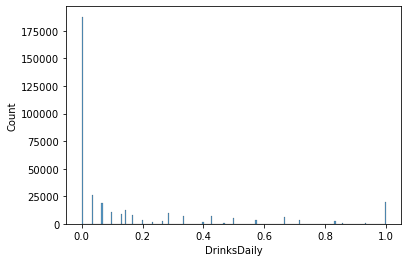

In [39]:
#print(temp1['DrinksDaily'].value_counts())
def my_recode(v):
    if v==888:
        return(0)
    elif v>0 and v<=107:
        return (v-100)/7
    elif v>107 and v<=230:
        return (v-200)/30
    else:
        return 0
temp1['DrinksDaily']= temp1['DrinksDaily'].apply(my_recode)
mysc=Scaler()
temp1['DrinksDaily']=mysc.fit_transform(temp1[['DrinksDaily']])
sns.histplot(data=temp1, x="DrinksDaily")

## High Cholesterol

1=Yes, 2=No, 7/9=DK/Refused

In [40]:
pd.crosstab(temp1.HighCholesterol,temp1.MI, normalize='index')

MI,0.0,1.0
HighCholesterol,,
1.0,0.891154,0.108846
2.0,0.958806,0.041194
7.0,0.901498,0.098502
9.0,0.960526,0.039474


In [41]:
print(pd.value_counts(temp1.HighCholesterol, normalize='columns'))
temp1['HighCholesterol']=temp1['HighCholesterol'].replace(dict(a_dict))
print(pd.value_counts(temp1.HighCholesterol, normalize='columns'))

2.0    0.590895
1.0    0.397697
7.0    0.010319
9.0    0.001088
Name: HighCholesterol, dtype: float64
0.0    0.602303
1.0    0.397697
Name: HighCholesterol, dtype: float64


## High BP

1=No, 2=Yes, 9=DK/Not Sure/Refused/Missing

In [42]:
print(pd.value_counts(temp1.HighBP, normalize='columns'))
p_dict={1:0, 2:1, 9:0}  #2 = YES
temp1['HighBP']=temp1['HighBP'].replace(dict(p_dict))
print(pd.value_counts(temp1.HighBP, normalize='columns'))

1.0    0.532815
2.0    0.463362
9.0    0.003823
Name: HighBP, dtype: float64
0.0    0.536638
1.0    0.463362
Name: HighBP, dtype: float64


## High BMI

1=No, 2=Yes, 9=DK/R/M

In [43]:
print(pd.value_counts(temp1.HighBMI, normalize='columns'))
temp1['HighBMI']=temp1['HighBMI'].replace(dict(p_dict))
print(pd.value_counts(temp1.HighBMI, normalize='columns'))

2.0    0.642839
1.0    0.273257
9.0    0.083904
Name: HighBMI, dtype: float64
1.0    0.642839
0.0    0.357161
Name: HighBMI, dtype: float64


## Diabetes

1=Yes, 2=During Pregnancy, 3=No, 4=No-prediabetes, 7=DK, 9=Refused

In [44]:
print(pd.value_counts(temp1.Diabetes, normalize='columns'))
q0_dict={1:1, 2:0, 3:0, 4:0, 7:0, 9:0} #diabetes
q1_dict={1:0, 2:0, 3:0, 4:1, 7:0, 9:0} #pre-diabetic
temp1['Diabetic']=temp1['Diabetes'].replace(dict(q0_dict))
temp1['Prediabetic']=temp1['Diabetes'].replace(dict(q1_dict))
temp1=temp1.drop(columns=['Diabetes'])
print(pd.value_counts(temp1.Diabetic, normalize='columns'))
print(pd.value_counts(temp1.Prediabetic, normalize='columns'))

3.0    0.803907
1.0    0.160948
4.0    0.024605
2.0    0.008507
7.0    0.001412
9.0    0.000621
Name: Diabetes, dtype: float64
0.0    0.839052
1.0    0.160948
Name: Diabetic, dtype: float64
0.0    0.975395
1.0    0.024605
Name: Prediabetic, dtype: float64


## Days Poor Physical Health

1-30=Number of Days, 88=0, 77=DK, 99=Refused

<AxesSubplot:xlabel='PhysicalHealth', ylabel='Count'>

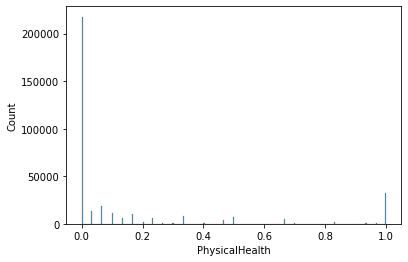

In [45]:
def my_recode2(v):
    if v>30:
        return(0)
    else:
        return(v)
    
    
temp1['PhysicalHealth']= temp1['PhysicalHealth'].apply(my_recode2)
temp1['PhysicalHealth']=mysc.fit_transform(temp1[['PhysicalHealth']])
sns.histplot(data=temp1, x="PhysicalHealth")

## Mental Health

1-30=Number of days, 88=None, 77/99=DK/Refused

<AxesSubplot:xlabel='MentalHealth', ylabel='Count'>

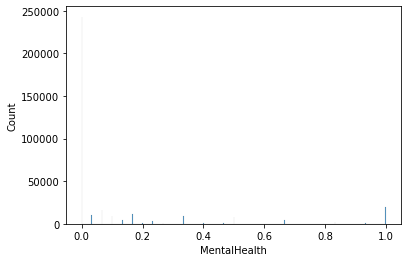

In [46]:
temp1['MentalHealth']= temp1['MentalHealth'].apply(my_recode2)
temp1['MentalHealth']=mysc.fit_transform(temp1[['MentalHealth']])
sns.histplot(data=temp1, x="MentalHealth")

## Depression

1=Yes, 2=No, 7/9=DK/R

In [47]:
print(pd.value_counts(temp1.Depression, normalize='columns'))
temp1['Depression']=temp1['Depression'].replace(dict(a_dict))
print(pd.value_counts(temp1.Depression, normalize='columns'))

2.0    0.812116
1.0    0.182684
7.0    0.003946
9.0    0.001254
Name: Depression, dtype: float64
0.0    0.817316
1.0    0.182684
Name: Depression, dtype: float64


## Stroke

1=Yes, 2=No, 7/9=DK/R

In [48]:
print(pd.value_counts(temp1.Stroke, normalize='columns'))
temp1['Stroke']=temp1['Stroke'].replace(dict(a_dict))
print(pd.value_counts(temp1.Stroke, normalize='columns'))

2.0    0.944045
1.0    0.052519
7.0    0.002941
9.0    0.000495
Name: Stroke, dtype: float64
0.0    0.947481
1.0    0.052519
Name: Stroke, dtype: float64


## Asthma

1=Yes, 2=No, 7/9=DK/R


In [49]:
print(pd.value_counts(temp1.Asthma, normalize='columns'))
temp1['Asthma']=temp1['Asthma'].replace(dict(a_dict))
print(pd.value_counts(temp1.Asthma, normalize='columns'))

2.0    0.862757
1.0    0.133709
7.0    0.003047
9.0    0.000487
Name: Asthma, dtype: float64
0.0    0.866291
1.0    0.133709
Name: Asthma, dtype: float64


## Skin Cancer

1=Yes, 2=No, 7/9=DK/R

In [50]:
print(pd.value_counts(temp1.SkinCancer, normalize='columns'))
temp1['SkinCancer']=temp1['SkinCancer'].replace(dict(a_dict))
print(pd.value_counts(temp1.SkinCancer, normalize='columns'))

2.0    0.878005
1.0    0.118376
7.0    0.003104
9.0    0.000515
Name: SkinCancer, dtype: float64
0.0    0.881624
1.0    0.118376
Name: SkinCancer, dtype: float64


## Cancer (Other than Skin)

1=Yes, 2=No, 7/9=DK/R


In [51]:
print(pd.value_counts(temp1.Cancer, normalize='columns'))
temp1['Cancer']=temp1['Cancer'].replace(dict(a_dict))
print(pd.value_counts(temp1.Cancer, normalize='columns'))

2.0    0.877366
1.0    0.119553
7.0    0.002279
9.0    0.000802
Name: Cancer, dtype: float64
0.0    0.880447
1.0    0.119553
Name: Cancer, dtype: float64


## COPD

1=Yes, 2=No, 7/9=DK/R

In [52]:
print(pd.value_counts(temp1.COPD, normalize='columns'))
temp1['COPD']=temp1['COPD'].replace(dict(a_dict))
print(pd.value_counts(temp1.COPD, normalize='columns'))

2.0    0.897040
1.0    0.097173
7.0    0.005200
9.0    0.000587
Name: COPD, dtype: float64
0.0    0.902827
1.0    0.097173
Name: COPD, dtype: float64


## Kidney Disease

1=Yes, 2=No, 7/9=DK/R

In [53]:
print(pd.value_counts(temp1.Kidney, normalize='columns'))
temp1['Kidney']=temp1['Kidney'].replace(dict(a_dict))
print(pd.value_counts(temp1.Kidney, normalize='columns'))

2.0    0.950851
1.0    0.044891
7.0    0.003697
9.0    0.000561
Name: Kidney, dtype: float64
0.0    0.955109
1.0    0.044891
Name: Kidney, dtype: float64


## Arthritis

1=Yes, 2=No, 7/9=DK/R

In [54]:
print(pd.value_counts(temp1.Arthritis, normalize='columns'))
temp1['Arthritis']=temp1['Arthritis'].replace(dict(a_dict))
print(pd.value_counts(temp1.Arthritis, normalize='columns'))

2.0    0.605994
1.0    0.387570
7.0    0.005752
9.0    0.000684
Name: Arthritis, dtype: float64
0.0    0.61243
1.0    0.38757
Name: Arthritis, dtype: float64


## No Health Plan         

1=Yes, 2=No, 7/9=DK/R

In [55]:
print(pd.value_counts(temp1.NoHealthPlan, normalize='columns'))
s_dict={1:0, 2:1, 7:0, 9:0} #2 is the assumed bad value
temp1['NoHealthPlan']=temp1['NoHealthPlan'].replace(dict(s_dict))
print(pd.value_counts(temp1.NoHealthPlan, normalize='columns'))

1.0    0.927953
2.0    0.068365
9.0    0.002119
7.0    0.001563
Name: NoHealthPlan, dtype: float64
0.0    0.931635
1.0    0.068365
Name: NoHealthPlan, dtype: float64


## No Personal Doctor

1=Yes only one, 2=Yes more than one, 3=No, 7/9=DK/R

In [56]:
print(pd.value_counts(temp1.NoDoctor, normalize='columns'))
t_dict={1:0, 2:0, 3:1, 7:1, 9:1} #3 is the assumed bad value
temp1['NoDoctor']=temp1['NoDoctor'].replace(dict(t_dict))
print(pd.value_counts(temp1.NoDoctor, normalize='columns'))

1.0    0.787031
3.0    0.126015
2.0    0.082991
7.0    0.002700
9.0    0.001263
Name: NoDoctor, dtype: float64
0.0    0.870022
1.0    0.129978
Name: NoDoctor, dtype: float64


## Medical Cost Prevented Care

1=Yes, 2=No, 7/9=DK/R

In [57]:
print(pd.value_counts(temp1.Cost, normalize='columns'))
temp1['Cost']=temp1['Cost'].replace(dict(a_dict))
print(pd.value_counts(temp1.Cost, normalize='columns'))

2.0    0.903855
1.0    0.093339
7.0    0.002208
9.0    0.000598
Name: Cost, dtype: float64
0.0    0.906661
1.0    0.093339
Name: Cost, dtype: float64


## Checkup within Year

1=within last year, 2=within past 2 years, 3=within past 5 years, 4=5 years+, 7=DK,8=Never, 9=Refused

In [58]:
print(pd.crosstab(temp1.NoCheckup,temp1.MI, normalize='index'))

MI              0.0       1.0
NoCheckup                    
1.0        0.924345  0.075655
2.0        0.965600  0.034400
3.0        0.970053  0.029947
4.0        0.970680  0.029320
7.0        0.926930  0.073070
8.0        0.957203  0.042797
9.0        0.940120  0.059880


In [59]:
print(pd.value_counts(temp1.NoCheckup, normalize='columns'))
u_dict={1:0, 2:1, 3:1, 4:1, 7:1, 8:1, 9:1}
temp1['NoCheckup']=temp1['NoCheckup'].replace(dict(u_dict))
print(temp1['NoCheckup'].value_counts())

1.0    0.830450
2.0    0.080322
4.0    0.037598
3.0    0.037576
7.0    0.008347
8.0    0.004750
9.0    0.000956
Name: NoCheckup, dtype: float64
0.0    290029
1.0     59214
Name: NoCheckup, dtype: int64


## Division Recodes

In [60]:
pd.crosstab(temp1.State, temp1.MI, normalize='index')

MI,0.0,1.0
State,,
1.0,0.919529,0.080471
2.0,0.948996,0.051004
4.0,0.929057,0.070943
5.0,0.904297,0.095703
6.0,0.949555,0.050445
8.0,0.953018,0.046982
9.0,0.947911,0.052089
10.0,0.933105,0.066895
11.0,0.947492,0.052508


In [61]:
v_dict={1:'D6', 2:'D9',   4:'D8',   5:'D7', 6:'D9',  8:'D8',  9:'D1', 10:'D5', 11:'D5', 
       12:'D5', 13:'D5', 15:'D9', 16:'D8', 17:'D3', 18:'D3', 19:'D4', 20:'D4', 21:'D6', 22:'D7',
       23:'D1', 24:'D5', 25:'D1', 26:'D3', 27:'D4', 28:'D6', 29:'D4', 30:'D8', 31:'D4', 32:'D8',
       33:'D1', 34: 'D2', 35:'D8', 36:'D2', 37:'D5', 38:'D4', 39:'D3', 40:'D7', 41:'D9', 42:'D2', 44:'D1', 45:'D5',
       46:'D4', 47:'D6', 48:'D7', 49:'D8', 50:'D1', 51:'D5', 53:'D9', 54:'D5', 55:'D3', 56:'D8', 66:'D10',
       72:'D10'}
temp1['Division']=temp1['State']
temp1['Division']=temp1['Division'].replace(dict(v_dict))
temp1['Division']=temp1['Division'].astype('str')
temp1=pd.get_dummies(temp1,columns=['Division'])


In [62]:
temp1.describe()

,MI,Male,Veteran,RentHome,PoorHealth,Smoker,ChewSnuff,NoExercise,DrinksDaily,HighCholesterol,...,Division_D1,Division_D10,Division_D2,Division_D3,Division_D4,Division_D5,Division_D6,Division_D7,Division_D8,Division_D9
count,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,...,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000
mean,0.068689,0.440676,0.141171,0.183517,0.060207,0.427530,0.029132,0.279101,0.153687,0.397697,...,0.117248,0.018867,0.048794,0.105179,0.170718,0.181770,0.063449,0.068574,0.130502,0.094900
std,0.252924,0.496469,0.348198,0.387090,0.237871,0.494721,0.168176,0.448558,0.277484,0.489423,...,0.321716,0.136054,0.215438,0.306784,0.376263,0.385656,0.243769,0.252729,0.336856,0.293077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.142857,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
temp1.shape

(349243, 62)

## Write CSV

In [64]:
temp1=temp1.drop(columns=['Division_D10']) 
temp1=temp1.drop(columns=['State']) 
temp1.to_csv('D:/MI/MI.csv', index=False)

# Describe
Pandas Profiling Report is too large for GitHub.

In [65]:
##############################################################################################################################
mydata=temp1 #reassign temp1 back to the original data frame but keep in temp1 
mydata=mydata.drop(columns=['Weights','Stratum', 'PSU']) #drop the weighting variables.
pd.set_option('display.max_columns', 500)
mydata.describe()
#pandas_profiling.ProfileReport(mydata)
##############################################################################################################################

,MI,Male,Veteran,RentHome,PoorHealth,Smoker,ChewSnuff,NoExercise,DrinksDaily,HighCholesterol,HighBP,HighBMI,PhysicalHealth,MentalHealth,Depression,Stroke,Asthma,SkinCancer,Cancer,COPD,Kidney,Arthritis,NoHealthPlan,NoDoctor,Cost,NoCheckup,Age65,Age55_64,Age45_54,Black,Hispanic,Other,PreviousMarriage,NeverMarried,LT25K,LT50K,Income_DKR,PreHS,HS,PostHS,RetiredUnable,OutofWork,OtherNotWorking,HealthDKR,FairHealth,GoodHealth,Diabetic,Prediabetic,Division_D1,Division_D2,Division_D3,Division_D4,Division_D5,Division_D6,Division_D7,Division_D8,Division_D9
count,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.00000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000,349243.000000
mean,0.068689,0.440676,0.141171,0.183517,0.060207,0.427530,0.029132,0.279101,0.153687,0.397697,0.463362,0.642839,0.158914,0.114314,0.182684,0.052519,0.133709,0.118376,0.119553,0.097173,0.044891,0.387570,0.068365,0.129978,0.093339,0.169550,0.442941,0.240566,0.174847,0.073823,0.073224,0.063809,0.319852,0.095349,0.201141,0.334641,0.174643,0.072666,0.261108,0.272655,0.44926,0.032390,0.058590,0.002631,0.152819,0.321109,0.160948,0.024605,0.117248,0.048794,0.105179,0.170718,0.181770,0.063449,0.068574,0.130502,0.094900
std,0.252924,0.496469,0.348198,0.387090,0.237871,0.494721,0.168176,0.448558,0.277484,0.489423,0.498657,0.479164,0.310409,0.260753,0.386408,0.223072,0.340340,0.323053,0.324438,0.296194,0.207066,0.487196,0.252372,0.336280,0.290907,0.375237,0.496734,0.427428,0.379837,0.261482,0.260504,0.244414,0.466420,0.293697,0.400854,0.471865,0.379662,0.259587,0.439239,0.445326,0.49742,0.177034,0.234855,0.051230,0.359814,0.466903,0.367484,0.154917,0.321716,0.215438,0.306784,0.376263,0.385656,0.243769,0.252729,0.336856,0.293077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000

# Build Training and Test Set

In [66]:
##############################################################################################################################
# Seed value for random number generators to obtain reproducible results
temp=mydata
temp=temp.values
tempy=temp[:,0]
tempx=temp[:,1:len(temp)]

X_train, X_test, y_train, y_test = tts(tempx, tempy, test_size=.2, random_state=1234)
X_train1, X_test1, y_train1,y_test1=X_train, X_test, y_train, y_test #Backup, NOT oversampled

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

##############################################################################################################################

# Functions for Confusion Matrix and PR Plot

In [67]:
def myf(mod):
    y_hat=mod.predict(X_test).astype(int) #can use either encoded or decoded data..doesn't help
    results=pd.DataFrame(CR(y_test, y_hat, output_dict=True))
    try:  
        plot_confusion_matrix(mod,X_test,y_test)
    except:
        print('No confusion plot.')
    return(results)

def prplot(mod):
    average_precision = average_precision_score(y_test, mod.predict(X_test))
    disp = plot_precision_recall_curve(mod, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Naive Bayes

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.969187,0.143247,0.683575,0.556217,0.911625
recall,0.681538,0.710764,0.683575,0.696151,0.683575
f1-score,0.800300,0.238440,0.683575,0.519370,0.761142
support,64981.000000,4868.000000,0.683575,69849.000000,69849.000000


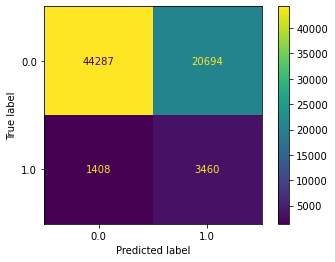

In [68]:
mynb=GaussianNB()
mynb.fit(X_train, y_train)
myf(mynb)

# K Nearest Neighbors

In [69]:
#myknn=KNN(2)
#myknn.fit(X_train, y_train)
#myf(myknn)
##Not Run.  

# Logistic Regression Models

## Elasticnet Regularization

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.974838,0.172402,0.732151,0.573620,0.918914
recall,0.730952,0.748151,0.732151,0.739552,0.732151
f1-score,0.835460,0.280229,0.732151,0.557845,0.796764
support,64981.000000,4868.000000,0.732151,69849.000000,69849.000000


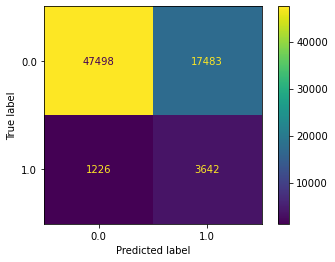

In [70]:
##############################################################################################################################
mylm=LR(fit_intercept = True, penalty='elasticnet', solver='saga', l1_ratio=.9) #logistic model with elasticnet
myfit2=mylm.fit(X_train, y_train)  #Fit on training data 
myf(mylm)
##############################################################################################################################

In [71]:
pr1=mylm.predict_proba(X_test)
cut=.5
pr1[pr1<cut]=0
pr1[pr1>=cut]=1
nw=pd.DataFrame(pr1, columns=('No','Yes'))
tmp=nw[['No','Yes']].idxmax(axis=1)
tmp[tmp=='Yes']=1
tmp[tmp=='No']=0
tmp=tmp.astype('float64')
ndf=pd.DataFrame({'Pred':tmp, 'Actual': y_test})
pd.crosstab(ndf.Actual,ndf.Pred)

Pred,0.0,1.0
Actual,,
0.0,47498,17483
1.0,1226,3642


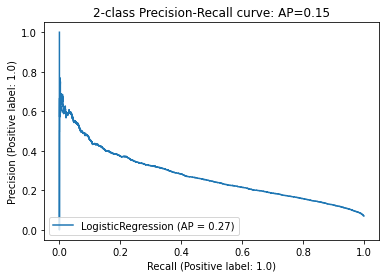

In [72]:
prplot(mylm)

## L2 Regularized Logistic Regression

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.974818,0.172371,0.732151,0.573595,0.918893
recall,0.730968,0.747946,0.732151,0.739457,0.732151
f1-score,0.835463,0.280174,0.732151,0.557818,0.796763
support,64981.000000,4868.000000,0.732151,69849.000000,69849.000000


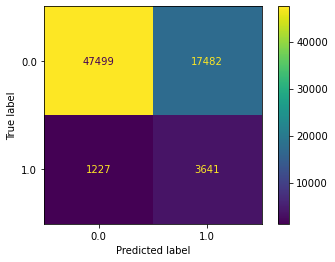

In [73]:
##############################################################################################################################
myrr=LR(fit_intercept = True, solver='liblinear', penalty='l2') #logistic model
myrr.fit(X_train, y_train)  #Fit on training data 
myf(myrr) #predict on test set and plot
##############################################################################################################################

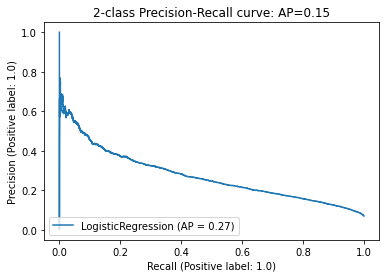

In [74]:
prplot(myrr)

## L1 Regularized Logistic Regression

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.974819,0.172380,0.732165,0.573599,0.918894
recall,0.730983,0.747946,0.732165,0.739464,0.732165
f1-score,0.835473,0.280185,0.732165,0.557829,0.796773
support,64981.000000,4868.000000,0.732165,69849.000000,69849.000000


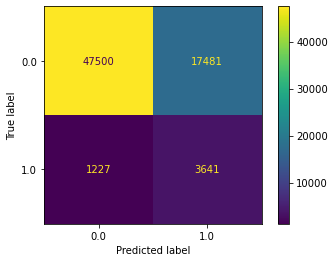

In [75]:
##############################################################################################################################
mylasso=LR(fit_intercept = True, solver='liblinear', penalty='l1') #logistic model
mylasso.fit(X_train, y_train)  #Fit on training data 
myf(mylasso) #predict on test set and plot
##############################################################################################################################

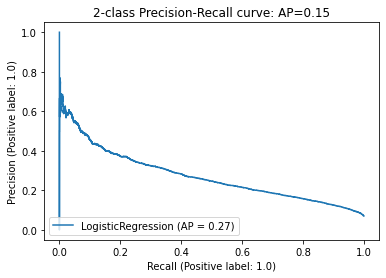

In [76]:
prplot(mylasso)

## SGD Classifier

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.974940,0.172903,0.732809,0.573921,0.919043
recall,0.731598,0.748973,0.732809,0.740286,0.732809
f1-score,0.835920,0.280948,0.732809,0.558434,0.797242
support,64981.000000,4868.000000,0.732809,69849.000000,69849.000000


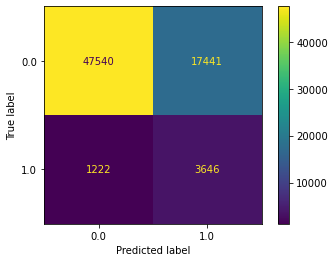

In [77]:
mysgd=SGD(loss='log', penalty='l1', alpha=0.001,fit_intercept=True, random_state=43)
mysgd.fit(X_train,y_train)
myf(mysgd)

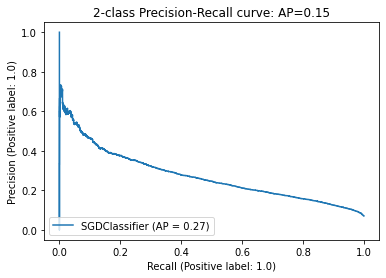

In [78]:
prplot(mysgd)

## Comparison of Coefficients

In [79]:
def flat(x):
    return(np.reshape(x,56))
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
p1, p2, p3, p4, p5=mydata.columns.values[1:57],flat(np.exp(mylm.coef_)),flat(np.exp(myrr.coef_)),flat(np.exp(mylasso.coef_)), flat(np.exp(mysgd.coef_))
pd.DataFrame(list(zip(p1, p2, p3, p4, p5)), columns=['Name','Elasticnet', 'L2', 'L1', 'SGD'])
#print(mylm.intercept_)

,Name,Elasticnet,L2,L1,SGD
0,Male,2.461421,2.460803,2.460271,2.271940
1,Veteran,1.049195,1.049462,1.049346,1.000000
2,RentHome,1.097997,1.098305,1.098147,1.015024
3,PoorHealth,3.943779,3.942564,3.943227,3.289329
4,Smoker,1.477709,1.477713,1.477570,1.443970
5,ChewSnuff,0.639393,0.639460,0.639409,0.840701
6,NoExercise,0.946515,0.946292,0.946350,1.000000
7,DrinksDaily,0.513504,0.513403,0.513358,0.547916
8,HighCholesterol,1.691116,1.691086,1.690942,1.689414
9,HighBP,1.923117,1.922955,1.922835,1.924069


# Tree Models

## Tree Plots

In [80]:
def mytree(mod):
    imp, std=mod.feature_importances_, np.std([mod.feature_importances_ for tree in mod.estimators_], axis=0)
    importances = pd.Series(imp, index=mydata.columns[1:57]).sort_values(ascending=False)[0:20]
    fig, ax = plt.subplots()
    importances.plot.bar(yerr=std[0:20], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

## Decision Tree Classifier

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.954519,0.194027,0.830563,0.574273,0.901518
recall,0.858789,0.453780,0.830563,0.656285,0.830563
f1-score,0.904127,0.271827,0.830563,0.587977,0.860060
support,64981.000000,4868.000000,0.830563,69849.000000,69849.000000


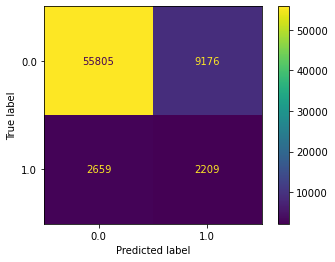

In [81]:
myTree=Tree(criterion='entropy', splitter='best', max_depth=8,min_samples_split=2, min_samples_leaf=1, random_state=123)
myTree.fit(X_train,y_train)
myf(myTree)

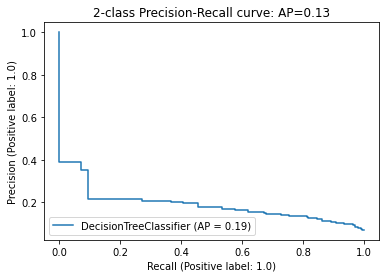

In [82]:
prplot(myTree)

## Random Forest Classifier

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.961556,0.208903,0.823577,0.585229,0.909101
recall,0.844108,0.549507,0.823577,0.696808,0.823577
f1-score,0.899012,0.302722,0.823577,0.600867,0.857455
support,64981.000000,4868.000000,0.823577,69849.000000,69849.000000


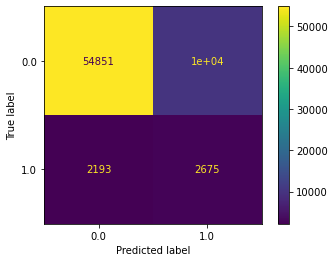

In [83]:
##############################################################################################################################
myrf=RFC(n_estimators = 100,max_depth=10,min_samples_split=2, criterion='entropy',bootstrap=True,                   
                            n_jobs = -1, random_state = 64) #RF Model
myrf.fit(X_train, y_train)  # Fit on the training set 
myf(myrf)
##############################################################################################################################

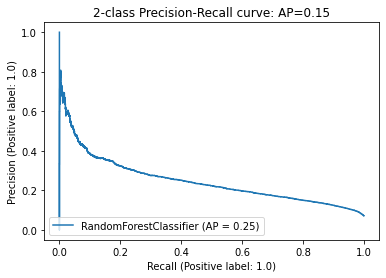

In [84]:
prplot(myrf)

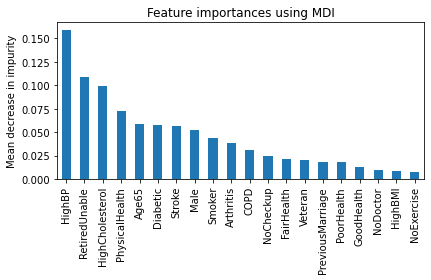

In [85]:
mytree(myrf)

## Extra Trees Classifier

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.952889,0.240294,0.86959,0.596591,0.903226
recall,0.904541,0.403040,0.86959,0.653791,0.869590
f1-score,0.928086,0.301082,0.86959,0.614584,0.884388
support,64981.000000,4868.000000,0.86959,69849.000000,69849.000000


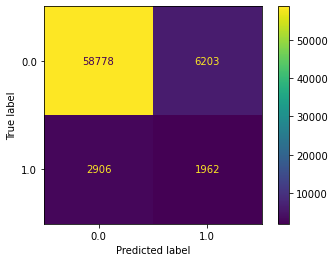

In [86]:
##############################################################################################################################
myextra=ETC(n_estimators = 50, max_depth=22, min_samples_split=2,criterion='entropy',
                           bootstrap=True, n_jobs = -1, random_state = 64) #previously tuned
myextra.fit(X_train, y_train)  #Fit on training set
myf(myextra)
#######################################################

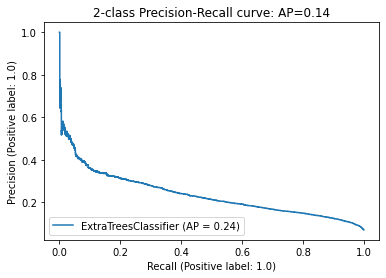

In [87]:
prplot(myextra)

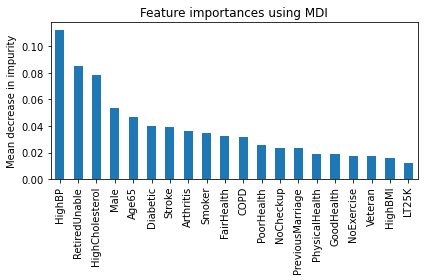

In [88]:
mytree(myextra)

##  Gradient Boosting

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.957132,0.234434,0.855932,0.595783,0.906765
recall,0.884766,0.471035,0.855932,0.677901,0.855932
f1-score,0.919528,0.313059,0.855932,0.616293,0.877261
support,64981.000000,4868.000000,0.855932,69849.000000,69849.000000


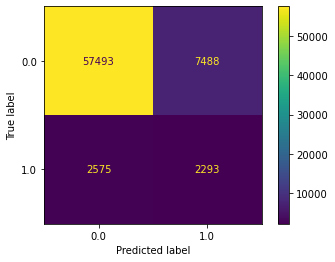

In [89]:
##############################################################################################################################
myGBC=GBC(n_estimators = 50, random_state = 64)
myGBC.fit(X_train, y_train)  #Fit on training set
myf(myGBC)
##############################################################################################################################

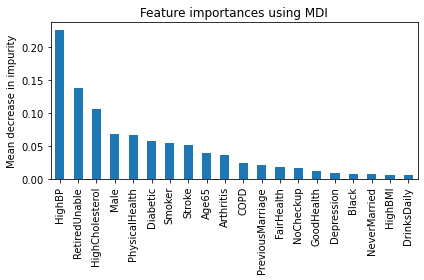

In [90]:
mytree(myGBC)

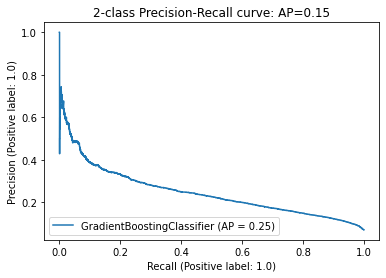

In [91]:
prplot(myGBC)

## ADA Boost Classifier

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.955958,0.214728,0.844565,0.585343,0.904299
recall,0.873148,0.463024,0.844565,0.668086,0.844565
f1-score,0.912678,0.293394,0.844565,0.603036,0.869518
support,64981.000000,4868.000000,0.844565,69849.000000,69849.000000


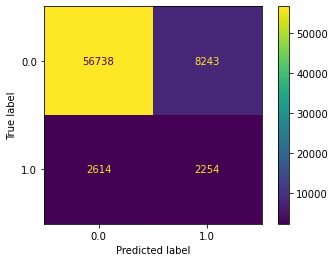

In [92]:
myADA=ABC(n_estimators=50, random_state=0)
myADA.fit(X_train,y_train)
myf(myADA)

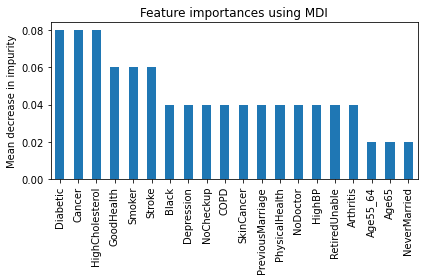

In [93]:
mytree(myADA)

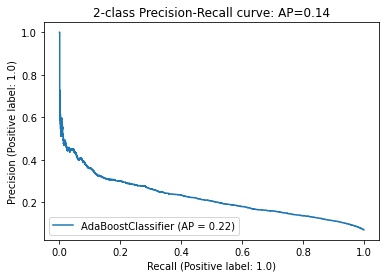

In [94]:
prplot(myADA)

# Discriminant Analysis

##  LDA

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.974989,0.169036,0.72495,0.572012,0.918820
recall,0.722888,0.752465,0.72495,0.737677,0.724950
f1-score,0.830223,0.276057,0.72495,0.553140,0.791601
support,64981.000000,4868.000000,0.72495,69849.000000,69849.000000


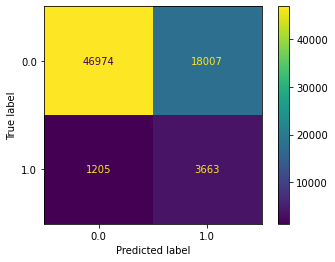

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
mylda=LDA()
mylda.fit(X_train, y_train)  # Fit on the training set 
myf(mylda)

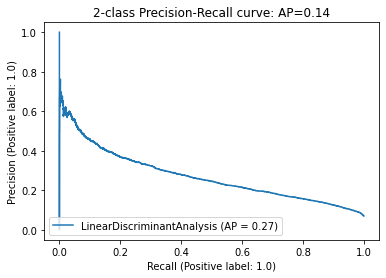

In [96]:
prplot(mylda)

# QDA

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.968166,0.131744,0.651219,0.549955,0.909873
recall,0.646343,0.716311,0.651219,0.681327,0.651219
f1-score,0.775179,0.222556,0.651219,0.498868,0.736665
support,64981.000000,4868.000000,0.651219,69849.000000,69849.000000


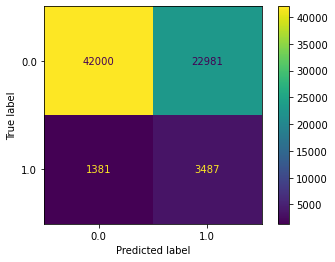

In [97]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
myqda=QDA()
myqda.fit(X_train, y_train)  #Fit on training set
myf(myqda)

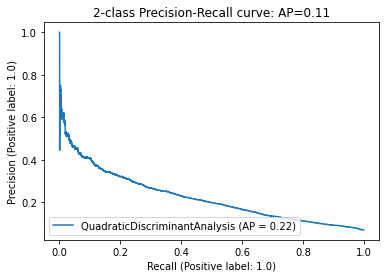

In [98]:
prplot(myqda)

# Linear Support Vector Machine

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.975087,0.170523,0.727655,0.572805,0.919014
recall,0.725797,0.752465,0.727655,0.739131,0.727655
f1-score,0.832173,0.278037,0.727655,0.555105,0.793554
support,64981.000000,4868.000000,0.727655,69849.000000,69849.000000


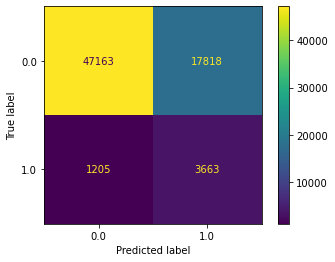

In [99]:
mysvm=LinearSVC(random_state=0, tol=1e-5)
mysvm.fit(X_train, y_train)  #Fit on training set
myf(mysvm)

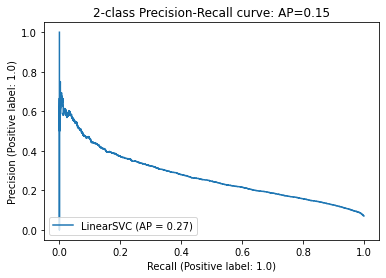

In [100]:
prplot(mysvm)